In [1]:
import igraph as ig
import scipy.sparse
import re
import numpy as np
from collections import Counter

from maxent_graph import bicm

Let's try projecting a bipartite network of senators and bills onto the senators. The data comes from the 116th congress, https://github.com/unitedstates/congress/wiki/bills

Read the graph in and construct a bipartite matrix using igraph. I prefer to use graph-tool, but it's not available on pypi. So, for simplicity

In [2]:
gn = "my_senate_116_bipartite"
g = ig.read(f"../data/{gn}.graphml", format="graphml")
assert g.is_bipartite()
B = scipy.sparse.csr_matrix(g.get_incidence()[0])

In [3]:
B

<4464x101 sparse matrix of type '<class 'numpy.int64'>'
	with 31589 stored elements in Compressed Sparse Row format>

By convention we project onto the rows. In this case I want the senators, who are on the columns currently. So, I transpose.

In [4]:
B = B.T

In [5]:
model = bicm.BICM(B)

Solve the equations to get the hidden variables for each node on both sides.

In [6]:
x0 = model.get_initial_guess()

In [7]:
solution = model.solve(x0, method="dogbox", verbose=True)

Took 0.6384716033935547 seconds
Relative error for expected degree/strength sequence: 

Percentile      Relative error
------------  ----------------
Min                0
25th               0
Median             0
75th               1.36152e-16
Max                3.55271e-16

Residual error: 2.991391024100063e-13


In [8]:
B.shape

(101, 4464)

Using the previously computed hidden variables, construct the projection using a particular p-value. To keep a record of *how* significant the edge is according to the null model, we keep the 'surprise' of the edge as a weight.

In [9]:
edgelist_with_weights = model.get_projection(solution.x, p_val=0.05)

Nonzero lambda-motif counts to check pval of 10195
Total possible pairs: 5050.0


0it [00:00, ?it/s]

Unique degrees (95, 77)
Total unique row degree pairs to check 4465.0


4465it [00:02, 1957.20it/s]


In [10]:
edgelist_with_weights[:5]

[(84, 58, 15.088134049558022),
 (84, 78, 3.105229880543371),
 (84, 92, 4.364146258295333),
 (84, 73, 7.623424425610103),
 (84, 46, 9.316469435089472)]

Let's visualize the results using igraph. Getting this weighted adjacency matrix into igraph is a bit annoying but here goes.. 

Following along here
https://igraph.org/python/doc/tutorial/tutorial.html#layouts-and-plotting

In [11]:
sources, targets, surprises = zip(*edgelist_with_weights)
edgelist = list(zip(sources, targets))
new_g = ig.Graph(B.shape[0], edgelist)

# probabilities kept as surprises (-np.log(p))
new_g.es["surprise"] = surprises

Make sure node/edge counts make sense

In [12]:
(new_g.vcount(), new_g.ecount())

(101, 1658)

In [13]:
# layout = new_g.layout_kamada_kawai()
# layout = new_g.layout_lgl()
layout = new_g.layout_fruchterman_reingold(weights=new_g.es["surprise"])

# trash
# layout = new_g.layout_drl(weights=new_g.es["surprise"])

Leiden is a good quick community detection algorithm.

In [14]:
clusters = new_g.community_leiden(
    objective_function="CPM",
    weights=new_g.es["surprise"],
    resolution_parameter=0.5,
    beta=0.01,
    initial_membership=None,
    n_iterations=10,
    node_weights=None,
)

In [15]:
for c in clusters:
    print(c)

[0, 2, 4, 6, 8, 9, 11, 13, 17, 18, 20, 22, 23, 24, 25, 26, 29, 30, 32, 33, 35, 36, 39, 42, 43, 44, 45, 46, 49, 52, 55, 58, 59, 62, 63, 67, 71, 72, 73, 75, 76, 78, 81, 82, 84, 85, 88, 90, 91, 92, 98, 100]
[1, 3, 5, 7, 10, 12, 14, 15, 16, 19, 21, 27, 28, 31, 34, 37, 38, 40, 41, 47, 48, 50, 51, 53, 57, 60, 61, 64, 65, 68, 70, 74, 77, 79, 80, 83, 86, 87, 89, 93, 94, 95, 96, 97, 99]
[54, 66]
[56]
[69]


Define colors based on community

In [16]:
# https://carto.com/carto-colors/
PASTEL_CARTO = [
    "#66C5CC",
    "#F6CF71",
    "#F89C74",
    "#DCB0F2",
    "#87C55F",
    "#9EB9F3",
    "#FE88B1",
    "#C9DB74",
    "#8BE0A4",
    "#B497E7",
    "#D3B484",
    "#B3B3B3",
]

In [17]:
assert len(clusters) <= len(PASTEL_CARTO)

In [18]:
community_assignment = [0 for _ in range(new_g.vcount())]

for i, c in enumerate(clusters):
    for v in c:
        community_assignment[v] = i

In [19]:
new_g.vs["color"] = [PASTEL_CARTO[c] for c in community_assignment]

In [20]:
state_party_re = re.compile(".*\((\w+)-(D|R|I)\)")

state = []
party = []
senator_names = g.vs["name"][: (B.shape[0])]
for n in senator_names:
    m = state_party_re.match(n)
    if m is None:
        print(n)
    s = m.group(1)
    p = m.group(2)
    state.append(s)
    party.append(p)

Counter(party)

Counter({'R': 54, 'D': 45, 'I': 2})

In [21]:
Counter(state)

Counter({'TN': 2,
         'WI': 2,
         'WY': 2,
         'CO': 2,
         'CT': 2,
         'MO': 2,
         'NJ': 2,
         'AR': 2,
         'IN': 2,
         'OH': 2,
         'NC': 2,
         'WA': 2,
         'WV': 2,
         'MD': 2,
         'DE': 2,
         'PA': 2,
         'LA': 2,
         'ME': 2,
         'TX': 2,
         'NV': 2,
         'ND': 2,
         'ID': 2,
         'MT': 2,
         'IL': 2,
         'IA': 2,
         'CA': 2,
         'NE': 2,
         'NY': 2,
         'SC': 2,
         'NH': 2,
         'NM': 2,
         'HI': 2,
         'MS': 2,
         'OK': 2,
         'GA': 3,
         'AL': 2,
         'VA': 2,
         'MN': 2,
         'VT': 2,
         'UT': 2,
         'MA': 2,
         'KY': 2,
         'AZ': 2,
         'OR': 2,
         'KS': 2,
         'AK': 2,
         'MI': 2,
         'RI': 2,
         'SD': 2,
         'FL': 2})

Only 2 Independents? :(

In [22]:
senator_names[0]

'Alexander, L. (TN-R)'

Let's define node shapes for the three parties

In [23]:
def map_party(p):
    if p == "R":
        return "square"
    elif p == "D":
        return "triangle"
    elif p == "I":
        return "circle"
    assert False

In [24]:
shapes = [map_party(p) for p in party]

In [25]:
shapes[:5]

['square', 'triangle', 'square', 'triangle', 'square']

In [26]:
new_g.vs["shape"] = shapes
new_g.vs["label"] = senator_names
new_g.vs["label_size"] = [6 for v in new_g.vs]

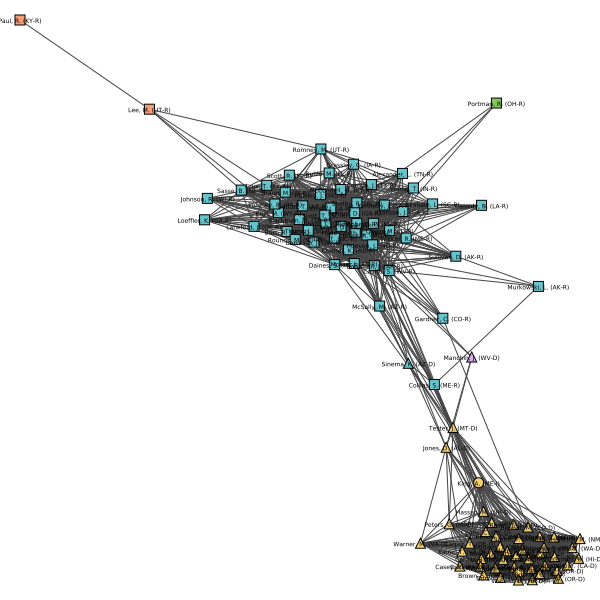

In [27]:
ig.plot(new_g, layout=layout, vertex_size=10)

Of course, with more space we would scale this and reduce overlap

As another sanity check, let's see if all the senators from the same state are connected. Use the state list from the regex we used earlier..

In [28]:
state[:5]

['TN', 'WI', 'WY', 'CO', 'TN']

In [29]:
unique = np.unique(state)

In [30]:
d = []
for st in unique:
    indices = [i for i, val in enumerate(state) if val == st]

    e = new_g.get_eid(indices[0], indices[1], error=False)

    # georgia technically has 3 senators because of a sub. just special case that
    if st == "GA":
        e = new_g.get_eid(indices[1], indices[2], error=False)

    if e != -1:
        surprise = surprises[e]
        d.append((st, surprise))
    else:
        n1 = senator_names[indices[0]]
        n2 = senator_names[indices[1]]
        print(f"No connection between the Senators from {st}: {n1} and {n2}!")

No connection between the Senators from AL: Jones, D. (AL-D) and Shelby, R. (AL-R)!
No connection between the Senators from KY: McConnell, M. (KY-R) and Paul, R. (KY-R)!
No connection between the Senators from OH: Brown, S. (OH-D) and Portman, R. (OH-R)!
No connection between the Senators from PA: Casey, R. (PA-D) and Toomey, P. (PA-R)!
No connection between the Senators from WI: Baldwin, T. (WI-D) and Johnson, R. (WI-R)!


In [31]:
len(d)

45

45/50. Seems correct! Notice that 4/5 of the non-connected Senators are mixed Democrat/Republican. Lone exception is Kentucky. Hmm?

I wonder which states have Senators cooperating the most?

In [32]:
sorted(d, key=lambda x: x[1], reverse=True)[:20]

[('ID', 66.25717070416822),
 ('NM', 59.60122974668484),
 ('MD', 59.591759678131005),
 ('MA', 57.16644076330453),
 ('NH', 49.06139939074652),
 ('OR', 46.692243505446655),
 ('IL', 46.61058946077267),
 ('MN', 44.39480680978657),
 ('NV', 44.28765597907773),
 ('RI', 41.96379111762018),
 ('ND', 37.891530355827825),
 ('MI', 36.40815464748457),
 ('VA', 36.26824513639169),
 ('MS', 35.94043225544598),
 ('CA', 33.27837853506378),
 ('NJ', 30.278045725466786),
 ('CT', 29.92116057960277),
 ('AK', 29.260328188513196),
 ('WY', 28.966577365518315),
 ('NY', 27.87219520160132)]